# Advanced Urban Analytics — Practice Session 2  
## Graph Neural Networks for Spatial-Explicit Urban Analytics: GCN & GraphSAGE

**Session focus:**  
- Build and train **GCN** and **GraphSAGE** models on different graph types  
- Compare behaviour across **synthetic**, **spatial kNN**, and **polygon contiguity** graphs  
- Connect implementations to urban interpretations (spatial spillovers, diffusion, neighbourhood effects)

### Learning objectives
By the end of this session, students should be able to:
1. Explain the intuition of message passing and how it differs between **GCN** and **GraphSAGE**.
2. Implement GCN and GraphSAGE using **PyTorch Geometric (PyG)**.
3. Create graphs from different sources (synthetic, spatial kNN, GeoJSON contiguity) and prepare node features/labels.
4. Train, evaluate, and compare models on node classification and regression tasks.
5. Understand practical issues: normalisation, train/val/test masks, class imbalance, over-smoothing, and scalability.

### Prerequisites
- Session 1 notebook (graphs, adjacency, Laplacian, centrality)
- Basic PyTorch familiarity is helpful but not required


## 0. Environment setup

We use:
- **PyTorch** + **PyTorch Geometric (PyG)** for GNNs
- `networkx`/`geopandas` for graph construction
- `numpy`, `pandas`, `matplotlib` for data handling and visualisation

If you run this in **Google Colab**, the install cell below is usually sufficient.


In [1]:
# Colab setup (uncomment if needed)
# !pip -q install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
!pip -q install torch-geometric
# !pip -q install networkx numpy pandas matplotlib geopandas shapely pyproj rtree

import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

import torch
import torch.nn.functional as F

print("torch:", torch.__version__)

# PyG imports
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx
from torch_geometric.nn import GCNConv, SAGEConv


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 58.7 MB/s eta 0:00:00
torch: 2.9.0+cpu


## 1. Core concept: Message passing

### GCN (Graph Convolutional Network)
\begin{align}
\mathbf{H}^{(\ell+1)} = \sigma\left(\tilde{\mathbf{D}}^{-1/2}\tilde{\mathbf{A}}\tilde{\mathbf{D}}^{-1/2}\mathbf{H}^{(\ell)}\mathbf{W}^{(\ell)}\right)
\end{align}
Intuition: a smoothed (normalised) average of neighbour features.

### GraphSAGE
\begin{align}
\mathbf{h}_v^{(\ell+1)} = \sigma\left(\mathbf{W}^{(\ell)} \cdot \mathrm{CONCAT}\left(\mathbf{h}_v^{(\ell)}, \mathrm{AGG}\left(\{\mathbf{h}_u^{(\ell)}: u\in \mathcal{N}(v)\}\right)\right)\right)
\end{align}
Intuition: explicit neighbour aggregation (often with sampling for large graphs).


## 2. Utility functions


In [71]:
def set_seed(seed: int = 42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

def make_masks(num_nodes: int, train_ratio=0.6, val_ratio=0.2, seed=42):
    rng = np.random.default_rng(seed)
    idx = np.arange(num_nodes)
    rng.shuffle(idx)
    n_train = int(train_ratio * num_nodes)
    n_val = int(val_ratio * num_nodes)
    train_idx = idx[:n_train]
    val_idx = idx[n_train:n_train+n_val]
    test_idx = idx[n_train+n_val:]

    train_mask = torch.zeros(num_nodes, dtype=torch.bool)
    val_mask   = torch.zeros(num_nodes, dtype=torch.bool)
    test_mask  = torch.zeros(num_nodes, dtype=torch.bool)
    train_mask[train_idx] = True
    val_mask[val_idx] = True
    test_mask[test_idx] = True
    return train_mask, val_mask, test_mask

def accuracy(logits, y):
    pred = logits.argmax(dim=1)
    return (pred == y).float().mean().item()

@torch.no_grad()
def evaluate_classification(model, data):
    model.eval()
    out = model(data.x, data.edge_index)
    acc_train = accuracy(out[data.train_mask], data.y[data.train_mask])
    acc_val   = accuracy(out[data.val_mask], data.y[data.val_mask])
    acc_test  = accuracy(out[data.test_mask], data.y[data.test_mask])
    return acc_train, acc_val, acc_test

@torch.no_grad()
def evaluate_regression(model, data):
    model.eval()
    pred = model(data.x, data.edge_index).view(-1)
    y = data.y.view(-1)
    def rmse(mask):
        return torch.sqrt(F.mse_loss(pred[mask], y[mask])).item()
    return rmse(data.train_mask), rmse(data.val_mask), rmse(data.test_mask)

@torch.no_grad()
def evaluate_regression_r2(model, data):
    model.eval()
    pred = model(data.x, data.edge_index).view(-1)
    y = data.y.view(-1)

    def r2(mask):
        y_true = y[mask]
        y_pred = pred[mask]
        ss_res = torch.sum((y_true - y_pred) ** 2)
        ss_tot = torch.sum((y_true - torch.mean(y_true)) ** 2)
        return (1 - ss_res / (ss_tot + 1e-12)).item()

    return r2(data.train_mask), r2(data.val_mask), r2(data.test_mask)


def plot_learning_curve(train_vals, val_vals, title, ylabel):
    plt.figure(figsize=(5.5, 3.2))
    plt.plot(train_vals, label="train")
    plt.plot(val_vals, label="val")
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel("epoch")
    plt.legend()
    plt.show()


## 3. Models: GCN and GraphSAGE (PyG)


In [3]:
class GCN(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, dropout=0.3):
        super().__init__()
        self.conv1 = GCNConv(in_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, out_dim)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x

class GraphSAGE(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, dropout=0.3, aggr="mean"):
        super().__init__()
        self.conv1 = SAGEConv(in_dim, hidden_dim, aggr=aggr)
        self.conv2 = SAGEConv(hidden_dim, out_dim, aggr=aggr)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x

class GCNReg(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim=32, dropout=0.2):
        super().__init__()
        self.conv1 = GCNConv(in_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, 1)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x

class SAGEReg(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim=32, dropout=0.2, aggr="mean"):
        super().__init__()
        self.conv1 = SAGEConv(in_dim, hidden_dim, aggr=aggr)
        self.conv2 = SAGEConv(hidden_dim, 1, aggr=aggr)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x


## 4. Task A — Node classification on a synthetic community graph (SBM)


In [4]:
set_seed(42)
sizes = [120, 120, 120]
p_in, p_out = 0.08, 0.01
probs = [[p_in if i==j else p_out for j in range(len(sizes))] for i in range(len(sizes))]

G_sbm = nx.stochastic_block_model(sizes, probs, seed=42)
num_nodes = G_sbm.number_of_nodes()

y = []
for i, size in enumerate(sizes):
    y += [i]*size
y = torch.tensor(y, dtype=torch.long)

F_dim = 16
prototypes = torch.eye(len(sizes), F_dim)
X = torch.zeros(num_nodes, F_dim)
start = 0
for c, size in enumerate(sizes):
    X[start:start+size] = prototypes[c] + 0.6*torch.randn(size, F_dim)
    start += size

data_sbm = from_networkx(G_sbm)
data_sbm.x = X
data_sbm.y = y
data_sbm.train_mask, data_sbm.val_mask, data_sbm.test_mask = make_masks(num_nodes, 0.6, 0.2, seed=42)

data_sbm


Data(edge_index=[2, 4096], block=[360], partition=[3], name='stochastic_block_model', num_nodes=360, x=[360, 16], y=[360], train_mask=[360], val_mask=[360], test_mask=[360])

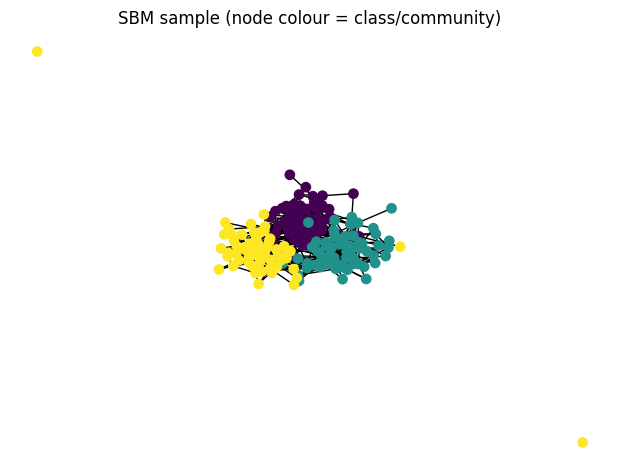

In [5]:
# Visualise a sample subgraph for clarity
sample_nodes = np.random.default_rng(42).choice(num_nodes, size=180, replace=False)
G_sub = G_sbm.subgraph(sample_nodes)

pos = nx.spring_layout(G_sub, seed=7)
plt.figure(figsize=(6, 4.3))
nx.draw(G_sub, pos, node_size=45, node_color=[y[n].item() for n in G_sub.nodes()])
plt.title("SBM sample (node colour = class/community)")
plt.axis("off")
plt.show()


epoch  20 | loss 0.392 | train 1.000 | val 0.986
epoch  40 | loss 0.075 | train 1.000 | val 1.000
epoch  60 | loss 0.029 | train 1.000 | val 1.000
epoch  80 | loss 0.023 | train 1.000 | val 1.000
epoch 100 | loss 0.014 | train 1.000 | val 1.000
epoch 120 | loss 0.013 | train 1.000 | val 1.000
Final (GCN) train/val/test: (1.0, 1.0, 1.0)


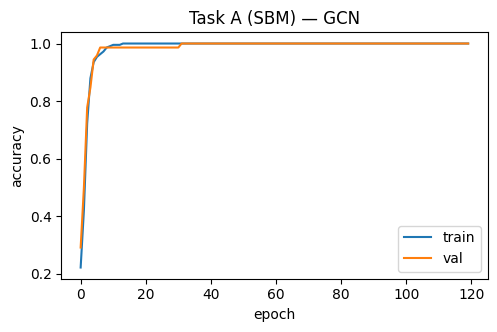

In [6]:
def train_node_classification(model, data, lr=0.01, weight_decay=5e-4, epochs=120):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    train_accs, val_accs = [], []
    for epoch in range(1, epochs+1):
        model.train()
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        acc_train, acc_val, _ = evaluate_classification(model, data)
        train_accs.append(acc_train)
        val_accs.append(acc_val)

        if epoch % 20 == 0:
            print(f"epoch {epoch:3d} | loss {loss.item():.3f} | train {acc_train:.3f} | val {acc_val:.3f}")
    return train_accs, val_accs

# GCN
gcn = GCN(in_dim=F_dim, hidden_dim=32, out_dim=len(sizes), dropout=0.3)
train_accs_gcn, val_accs_gcn = train_node_classification(gcn, data_sbm)
print("Final (GCN) train/val/test:", evaluate_classification(gcn, data_sbm))
plot_learning_curve(train_accs_gcn, val_accs_gcn, "Task A (SBM) — GCN", "accuracy")


epoch  20 | loss 0.121 | train 0.981 | val 1.000
epoch  40 | loss 0.017 | train 1.000 | val 1.000
epoch  60 | loss 0.007 | train 1.000 | val 1.000
epoch  80 | loss 0.006 | train 1.000 | val 1.000
epoch 100 | loss 0.004 | train 1.000 | val 1.000
epoch 120 | loss 0.004 | train 1.000 | val 1.000
Final (GraphSAGE) train/val/test: (1.0, 1.0, 0.9722222089767456)


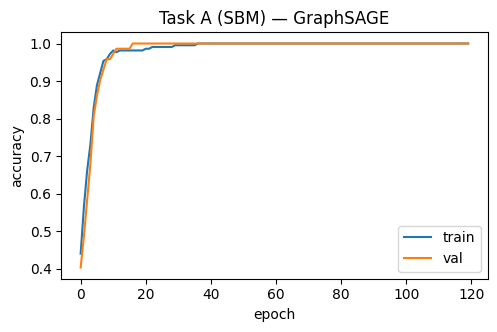

In [7]:
# GraphSAGE
sage = GraphSAGE(in_dim=F_dim, hidden_dim=32, out_dim=len(sizes), dropout=0.3, aggr="mean")
train_accs_sage, val_accs_sage = train_node_classification(sage, data_sbm)
print("Final (GraphSAGE) train/val/test:", evaluate_classification(sage, data_sbm))
plot_learning_curve(train_accs_sage, val_accs_sage, "Task A (SBM) — GraphSAGE", "accuracy")


## 5. Task B — Spatial regression on a kNN graph (synthetic coordinates)


In [8]:
set_seed(42)
N = 600
coords = np.random.default_rng(42).uniform(0, 1, size=(N, 2))

X = np.column_stack([coords, np.random.default_rng(7).normal(0, 1, size=(N, 6))]).astype(np.float32)
X = torch.tensor(X, dtype=torch.float32)

x, ycoord = coords[:, 0], coords[:, 1]
target = np.sin(2*np.pi*x) * np.cos(2*np.pi*ycoord) + 0.15*np.random.default_rng(5).normal(0, 1, size=N)
target = torch.tensor(target, dtype=torch.float32).view(-1, 1)

k = 8
d2 = ((coords[:, None, :] - coords[None, :, :])**2).sum(axis=2)
nn_idx = np.argsort(d2, axis=1)[:, 1:k+1]

edges = []
for i in range(N):
    for j in nn_idx[i]:
        edges.append((i, int(j)))
        edges.append((int(j), i))

edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

data_knn = Data(x=X, edge_index=edge_index, y=target)
data_knn.train_mask, data_knn.val_mask, data_knn.test_mask = make_masks(N, 0.6, 0.2, seed=42)

data_knn


Data(x=[600, 8], edge_index=[2, 9600], y=[600, 1], train_mask=[600], val_mask=[600], test_mask=[600])

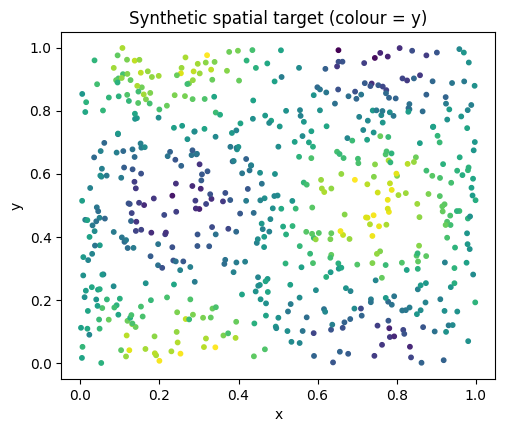

In [9]:
plt.figure(figsize=(5.6, 4.5))
plt.scatter(coords[:,0], coords[:,1], c=data_knn.y.view(-1).numpy(), s=10)
plt.title("Synthetic spatial target (colour = y)")
plt.xlabel("x")
plt.ylabel("y")
plt.show()


epoch  30 | loss 0.1158 | rmse train 0.3329 | val 0.3250
epoch  60 | loss 0.0648 | rmse train 0.2481 | val 0.2888
epoch  90 | loss 0.0585 | rmse train 0.2219 | val 0.2572
epoch 120 | loss 0.0601 | rmse train 0.2106 | val 0.2572
epoch 150 | loss 0.0509 | rmse train 0.2039 | val 0.2534
Final (GCN) RMSE train/val/test: (0.2038881480693817, 0.25335073471069336, 0.23546983301639557)


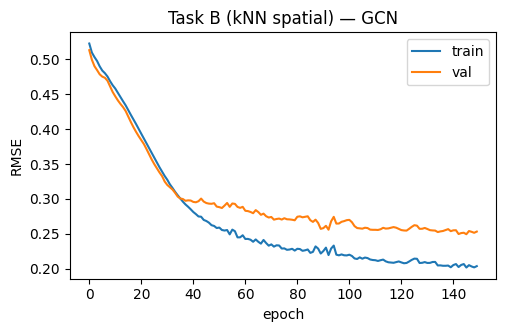

In [10]:
def train_node_regression(model, data, lr=0.01, weight_decay=1e-4, epochs=150):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    train_rmse, val_rmse = [], []
    for epoch in range(1, epochs+1):
        model.train()
        optimizer.zero_grad()
        pred = model(data.x, data.edge_index).view(-1)
        y = data.y.view(-1)
        loss = F.mse_loss(pred[data.train_mask], y[data.train_mask])
        loss.backward()
        optimizer.step()

        r_train, r_val, _ = evaluate_regression(model, data)
        train_rmse.append(r_train)
        val_rmse.append(r_val)

        if epoch % 30 == 0:
            print(f"epoch {epoch:3d} | loss {loss.item():.4f} | rmse train {r_train:.4f} | val {r_val:.4f}")
    return train_rmse, val_rmse

gcn_reg = GCNReg(in_dim=data_knn.x.size(1), hidden_dim=48, dropout=0.2)
train_rmse_gcn, val_rmse_gcn = train_node_regression(gcn_reg, data_knn)
print("Final (GCN) RMSE train/val/test:", evaluate_regression(gcn_reg, data_knn))
plot_learning_curve(train_rmse_gcn, val_rmse_gcn, "Task B (kNN spatial) — GCN", "RMSE")


epoch  30 | loss 0.1604 | rmse train 0.3813 | val 0.4379
epoch  60 | loss 0.0762 | rmse train 0.2394 | val 0.3178
epoch  90 | loss 0.0624 | rmse train 0.1930 | val 0.2868
epoch 120 | loss 0.0491 | rmse train 0.1786 | val 0.2602
epoch 150 | loss 0.0385 | rmse train 0.1610 | val 0.2621
Final (GraphSAGE) RMSE train/val/test: (0.16101084649562836, 0.2621457278728485, 0.2527453899383545)


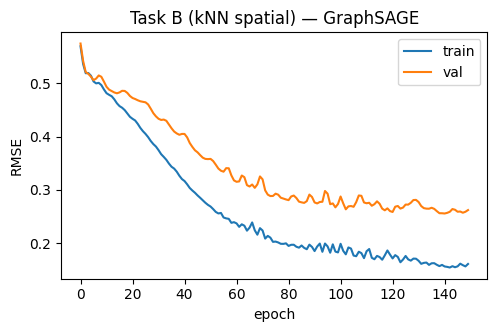

In [11]:
sage_reg = SAGEReg(in_dim=data_knn.x.size(1), hidden_dim=48, dropout=0.2, aggr="mean")
train_rmse_sage, val_rmse_sage = train_node_regression(sage_reg, data_knn)
print("Final (GraphSAGE) RMSE train/val/test:", evaluate_regression(sage_reg, data_knn))
plot_learning_curve(train_rmse_sage, val_rmse_sage, "Task B (kNN spatial) — GraphSAGE", "RMSE")


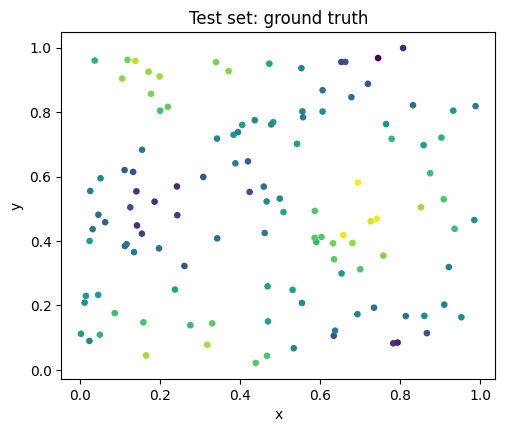

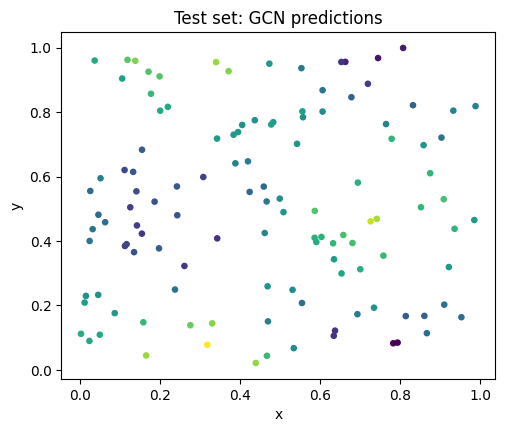

In [12]:
@torch.no_grad()
def predict(model, data):
    model.eval()
    return model(data.x, data.edge_index).view(-1).cpu().numpy()

pred_gcn = predict(gcn_reg, data_knn)
truth = data_knn.y.view(-1).cpu().numpy()
test_mask = data_knn.test_mask.cpu().numpy()

plt.figure(figsize=(5.6, 4.5))
plt.scatter(coords[test_mask,0], coords[test_mask,1], c=truth[test_mask], s=14)
plt.title("Test set: ground truth")
plt.xlabel("x"); plt.ylabel("y")
plt.show()

plt.figure(figsize=(5.6, 4.5))
plt.scatter(coords[test_mask,0], coords[test_mask,1], c=pred_gcn[test_mask], s=14)
plt.title("Test set: GCN predictions")
plt.xlabel("x"); plt.ylabel("y")
plt.show()


## 6. Task C — Contiguity graph + tabular features/targets (GeoJSON + CSV)

In many urban analytics workflows, **geometry** and **attributes** are stored separately:

- **GeoJSON** provides polygon geometries (spatial units) used to define **contiguity** (Queen/Rook) edges.
- A **features CSV** provides node attributes \( \mathbf{X} \) (e.g., socio-economic indicators, built environment proxies).
- A **target CSV** provides outcomes \( \mathbf{y} \) (e.g., deprivation index, exposure, risk score).

In this task we will:
1. Load polygons from a GeoJSON and build a **Queen or Rook** contiguity graph.
2. Load node features \( \mathbf{X} \) from a CSV and align them to polygons by a shared area identifier.
3. Load targets \( \mathbf{y} \) from a CSV and align them to the same nodes.
4. Train and compare **GCN** vs **GraphSAGE** on this **area-level** graph.

Typical urban applications:
- small-area estimation and spatial smoothing with learned representations
- neighbourhood-effect modelling (spillovers across adjacent areas)
- citywide exposure modelling at administrative unit level


In [32]:
import geopandas as gpd

# Paths (provided with the teaching materials)
geojson_path = "OA_Subset.geojson"
features_csv_path = "subset_oa_features.csv"
target_csv_path   = "subset_oa_target.csv"

gdf = gpd.read_file(geojson_path)
feat = pd.read_csv(features_csv_path)
tgt  = pd.read_csv(target_csv_path)

print("GeoJSON:", gdf.shape, "| Features CSV:", feat.shape, "| Target CSV:", tgt.shape)
gdf.head(2)


GeoJSON: (1193, 2) | Features CSV: (26369, 14) | Target CSV: (26369, 2)


,OA21CD,geometry
0,E00003601,"MULTIPOLYGON (((533941.857 170548.083, 533866...."
1,E00003605,"MULTIPOLYGON (((533703.755 170359.021, 533730...."


### 6.1 Identify the join key and align tables

We need a **shared identifier** across:
- the GeoJSON polygons
- the features table
- the target table

Because column names vary by dataset, the cell below tries to **auto-detect** a reasonable join key
by checking overlaps between column names (case-insensitive).

If the auto-detection does not pick the intended column, override it by setting `join_key = "YOUR_COLUMN"`.


In [33]:
# Inspect column names quickly (top candidates)
print("GeoJSON columns:", list(gdf.columns)[:20])
print("Features columns:", list(feat.columns)[:20])
print("Target columns:", list(tgt.columns)[:20])


GeoJSON columns: ['OA21CD', 'geometry']
Features columns: ['OA21CD', 'ownership_shared', 'social_rented', 'private_rented', 'occupancy_plus1', 'occupancy_minus1', 'disability_ratio', 'no_unpaid_care', 'two_cars_vans', 'qual_level_1_2', 'qual_level_3', 'qual_level_4plus', 'job_part_time', 'job_full_time']
Target columns: ['OA21CD', 'Pop_count']


In [34]:
import re

def normalise_cols(cols):
    return {c: re.sub(r"[^a-z0-9]+", "", c.lower()) for c in cols}

g_cols = normalise_cols(gdf.columns)
f_cols = normalise_cols(feat.columns)
t_cols = normalise_cols(tgt.columns)

# Candidate join keys (common patterns for Output Areas)
preferred_patterns = [
    "oa", "oacode", "oa11cd", "oa21cd", "geocode", "code", "areacode", "zonecode", "id"
]

# Find overlaps by normalised name
overlaps = set(g_cols.values()) & set(f_cols.values()) & set(t_cols.values())

def pick_join_key():
    # Prefer overlaps that match common patterns
    for p in preferred_patterns:
        if p in overlaps:
            # map back to original column name in GeoJSON (any table works; use GeoJSON for canonical)
            for orig, norm in g_cols.items():
                if norm == p:
                    return orig
    # Otherwise pick the first overlap (deterministic)
    if len(overlaps) > 0:
        first = sorted(overlaps)[0]
        for orig, norm in g_cols.items():
            if norm == first:
                return orig
    return None

join_key = pick_join_key()
join_key

'OA21CD'

In [35]:
# If auto-detection fails, set join_key manually here:
# join_key = "OA11CD"

assert join_key is not None, "No join key detected. Set join_key manually to the shared ID column."
print("Using join key:", join_key)


Using join key: OA21CD


In [36]:
# Harmonise key names across tables by creating a common 'join_id' column
# (This avoids having to rename columns permanently.)
def make_join_id(df, key):
    # find matching column in df by normalised name match to GeoJSON join_key
    key_norm = re.sub(r"[^a-z0-9]+", "", key.lower())
    norm_map = normalise_cols(df.columns)
    # exact match
    for col, norm in norm_map.items():
        if norm == key_norm:
            return df[col].astype(str)
    # fallback: try any preferred patterns present
    for p in [key_norm] + preferred_patterns:
        for col, norm in norm_map.items():
            if norm == p:
                return df[col].astype(str)
    raise KeyError(f"Could not locate join key '{key}' in table.")

gdf = gdf.copy()
gdf["join_id"] = make_join_id(gdf, join_key)

feat = feat.copy()
feat["join_id"] = make_join_id(feat, join_key)

tgt = tgt.copy()
tgt["join_id"] = make_join_id(tgt, join_key)

# Align: keep only units present in all three
common_ids = set(gdf["join_id"]) & set(feat["join_id"]) & set(tgt["join_id"])
print("Common units:", len(common_ids))

gdf = gdf[gdf["join_id"].isin(common_ids)].reset_index(drop=True)
feat = feat[feat["join_id"].isin(common_ids)].reset_index(drop=True)
tgt = tgt[tgt["join_id"].isin(common_ids)].reset_index(drop=True)

gdf.shape, feat.shape, tgt.shape


Common units: 1193


((1193, 3), (1193, 15), (1193, 3))

### 6.2 Descriptive analysis (features + target)

At minimum, inspect:
- number of units after alignment
- feature dimensionality
- missingness
- target distribution

This helps avoid common pitfalls: non-numeric dtypes, missing values, heavy tails, or leakage columns.


In [59]:
# Identify numeric feature columns (exclude join_id)
feature_cols = [c for c in feat.columns if c != "join_id"]
# Coerce to numeric where possible
for c in feature_cols:
    feat[c] = pd.to_numeric(feat[c], errors="coerce")

numeric_feature_cols = [c for c in feature_cols if pd.api.types.is_numeric_dtype(feat[c])]
print("Numeric feature columns:", len(numeric_feature_cols))

# Target: try to detect a single numeric target column (excluding join_id)
target_cols = ['Pop_count']

numeric_target_cols = [c for c in target_cols if pd.api.types.is_numeric_dtype(tgt[c])]
print("Numeric target columns:", numeric_target_cols)

# Choose target column (default: first numeric target column)
target_col = numeric_target_cols[0] if len(numeric_target_cols) > 0 else None
target_col


Numeric feature columns: 14
Numeric target columns: ['Pop_count']


'Pop_count'

In [60]:
assert target_col is not None, "No numeric target column detected in target CSV."

# Missingness
miss_feat = feat[numeric_feature_cols].isna().mean().sort_values(ascending=False)
miss_tgt = tgt[[target_col]].isna().mean()

print("Top missingness (features):")
print(miss_feat.head(10))
print("\nMissingness (target):")
print(miss_tgt)


Top missingness (features):
OA21CD              1.0
ownership_shared    0.0
social_rented       0.0
private_rented      0.0
occupancy_plus1     0.0
occupancy_minus1    0.0
disability_ratio    0.0
no_unpaid_care      0.0
two_cars_vans       0.0
qual_level_1_2      0.0
dtype: float64

Missingness (target):
Pop_count    0.0
dtype: float64


In [61]:
# Basic descriptive stats
desc_feat = feat[numeric_feature_cols].describe().T
desc_tgt  = tgt[[target_col]].describe().T
desc_feat.head(12), desc_tgt


(                   count      mean       std       min       25%       50%  \
 OA21CD               0.0       NaN       NaN       NaN       NaN       NaN   
 ownership_shared  1193.0  0.839879  0.105305  0.000000  0.792688  0.863003   
 social_rented     1193.0  0.616395  0.218108  0.000000  0.479197  0.634379   
 private_rented    1193.0  0.755066  0.103187  0.000000  0.697967  0.768993   
 occupancy_plus1   1193.0  0.731525  0.082525  0.281649  0.690008  0.739299   
 occupancy_minus1  1193.0  0.512772  0.155543  0.000000  0.435620  0.534049   
 disability_ratio  1193.0  0.785875  0.049752  0.000000  0.757801  0.786722   
 no_unpaid_care    1193.0  0.792866  0.076037  0.495082  0.744574  0.799725   
 two_cars_vans     1193.0  0.604225  0.156184  0.000000  0.523371  0.618981   
 qual_level_1_2    1193.0  0.543917  0.142008  0.000000  0.467833  0.576245   
 qual_level_3      1193.0  0.506669  0.081656  0.114399  0.457369  0.515645   
 qual_level_4plus  1193.0  0.744886  0.126638  0.326

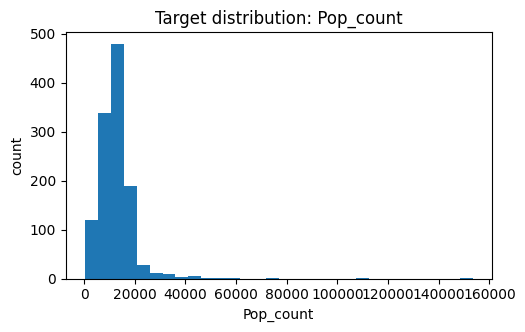

In [63]:
# Quick target distribution plot
plt.figure(figsize=(5.5, 3.2))
plt.hist(tgt[target_col].dropna().values, bins=30)
plt.title(f"Target distribution: {target_col}")
plt.xlabel(target_col)
plt.ylabel("count")
plt.show()


### 6.3 Build a contiguity graph (Queen/Rook) from polygons

- **Queen:** neighbours share a point or edge (denser graph)
- **Rook:** neighbours share an edge segment only (sparser graph)

We then create a PyG `Data` object with:
- node features $( \mathbf{X} )$ from the features CSV
- targets $( \mathbf{y} )$ from the target CSV
- `edge_index` from contiguity


In [64]:
# Fix geometries (common minor topology issues)
gdf = gdf.copy()
gdf["geometry"] = gdf["geometry"].buffer(0)
gdf = gdf[gdf.geometry.notnull()].reset_index(drop=True)

def build_contiguity_graph(polys_gdf: gpd.GeoDataFrame, id_col: str, kind: str = "queen") -> nx.Graph:
    assert kind in {"queen", "rook"}
    Gc = nx.Graph()
    Gc.add_nodes_from(polys_gdf[id_col].tolist())

    sindex = polys_gdf.sindex
    geoms = polys_gdf.geometry.values
    ids = polys_gdf[id_col].values

    for i, geom_i in enumerate(geoms):
        cand_idx = list(sindex.intersection(geom_i.bounds))
        for j in cand_idx:
            if j <= i:
                continue
            geom_j = geoms[j]
            if kind == "queen":
                if geom_i.touches(geom_j):
                    Gc.add_edge(ids[i], ids[j])
            else:
                inter = geom_i.boundary.intersection(geom_j.boundary)
                if (not inter.is_empty) and getattr(inter, "length", 0.0) > 0:
                    Gc.add_edge(ids[i], ids[j])
    return Gc

# Choose contiguity type
contiguity = "queen"  # set to "rook" if desired
G_poly = build_contiguity_graph(gdf, id_col="join_id", kind=contiguity)

print("Contiguity:", contiguity, "| nodes:", G_poly.number_of_nodes(), "| edges:", G_poly.number_of_edges())
print("Connected components:", nx.number_connected_components(G_poly))


Contiguity: queen | nodes: 1193 | edges: 3446
Connected components: 1


In [65]:
# Prepare X and y, aligned to the GeoJSON order (join_id)
node_order = gdf["join_id"].tolist()
feat_aligned = feat.set_index("join_id").loc[node_order, numeric_feature_cols]
tgt_aligned  = tgt.set_index("join_id").loc[node_order, target_col]

# Impute missing feature values with 0 (teaching default); consider better strategies in real projects
X_df = feat_aligned.fillna(0.0).astype(float)

# Standardise features (z-score) for training stability
X_std = (X_df - X_df.mean()) / (X_df.std() + 1e-8)
X = torch.tensor(X_std.values, dtype=torch.float32)

# Target: impute missing with mean (or drop nodes in real workflow)
y_series = tgt_aligned.astype(float)
y_filled = y_series.fillna(y_series.mean())
y = torch.tensor(y_filled.values, dtype=torch.float32).view(-1, 1)

print("X:", X.shape, "| y:", y.shape)


X: torch.Size([1193, 14]) | y: torch.Size([1193, 1])


In [66]:
# Build edge_index in PyG format (bidirectional)
node_to_idx = {n:i for i,n in enumerate(node_order)}
edges = []
for u, v in G_poly.edges():
    edges.append((node_to_idx[u], node_to_idx[v]))
    edges.append((node_to_idx[v], node_to_idx[u]))
edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

data_poly = Data(x=X, edge_index=edge_index, y=y)
data_poly.train_mask, data_poly.val_mask, data_poly.test_mask = make_masks(data_poly.num_nodes, 0.6, 0.2, seed=42)
data_poly


Data(x=[1193, 14], edge_index=[2, 6892], y=[1193, 1], train_mask=[1193], val_mask=[1193], test_mask=[1193])

<Figure size 620x620 with 0 Axes>

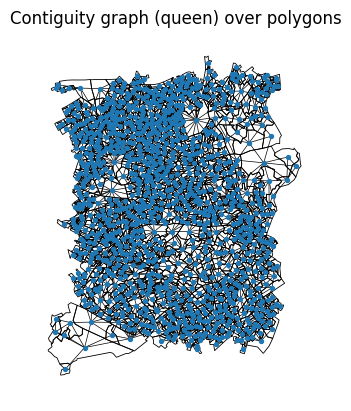

In [67]:
# Visualise polygons and the contiguity edges (centroid lines) for sanity checking
gdf["centroid"] = gdf.geometry.centroid
pos = {row["join_id"]: (row["centroid"].x, row["centroid"].y) for _, row in gdf.iterrows()}

plt.figure(figsize=(6.2, 6.2))
ax = gdf.plot(edgecolor="black", linewidth=0.6, facecolor="none")
nx.draw(G_poly, pos=pos, node_size=8, width=0.5, ax=ax)
plt.title(f"Contiguity graph ({contiguity}) over polygons")
plt.axis("off")
plt.show()


### 6.4 Train GCN vs GraphSAGE on the contiguity graph (regression)

We use the same training loop as Task B (MSE loss), reporting RMSE on train/val/test splits.


epoch  30 | loss 250350544.0000 | rmse train 15821.5586 | val 14067.0557
epoch  60 | loss 249063792.0000 | rmse train 15779.3623 | val 14019.3896
epoch  90 | loss 246192496.0000 | rmse train 15687.4795 | val 13916.0156
epoch 120 | loss 241559344.0000 | rmse train 15536.8613 | val 13746.8076
epoch 150 | loss 235114416.0000 | rmse train 15327.0420 | val 13511.0654
epoch 180 | loss 227374272.0000 | rmse train 15064.0713 | val 13215.1904
epoch 210 | loss 218125984.0000 | rmse train 14755.6113 | val 12867.2793
epoch 240 | loss 208126656.0000 | rmse train 14407.9014 | val 12473.7148
epoch 270 | loss 196994864.0000 | rmse train 14028.3604 | val 12042.4551
epoch 300 | loss 185866048.0000 | rmse train 13628.1543 | val 11585.6562
epoch 330 | loss 174957536.0000 | rmse train 13215.7637 | val 11112.6484
epoch 360 | loss 164685488.0000 | rmse train 12801.3291 | val 10635.2910
epoch 390 | loss 154824672.0000 | rmse train 12397.6494 | val 10168.5625
epoch 420 | loss 145129376.0000 | rmse train 12014.

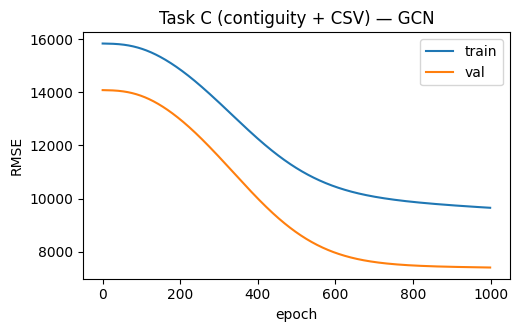

In [74]:
gcn_reg_poly = GCNReg(in_dim=data_poly.x.size(1), hidden_dim=64, dropout=0.2)
train_rmse_gcn_poly, val_rmse_gcn_poly = train_node_regression(gcn_reg_poly, data_poly, epochs=1000)
print("Final (GCN) RMSE train/val/test:", evaluate_regression(gcn_reg_poly, data_poly))
print("Final (GCN) R2   train/val/test:", evaluate_regression_r2(gcn_reg_poly, data_poly))

plot_learning_curve(train_rmse_gcn_poly, val_rmse_gcn_poly, "Task C (contiguity + CSV) — GCN", "RMSE")


epoch  30 | loss 248992160.0000 | rmse train 15775.1279 | val 14016.5752
epoch  60 | loss 241260560.0000 | rmse train 15520.4648 | val 13735.7568
epoch  90 | loss 225939712.0000 | rmse train 15006.9688 | val 13169.7168
epoch 120 | loss 204479584.0000 | rmse train 14261.3535 | val 12347.9492
epoch 150 | loss 179215376.0000 | rmse train 13364.8965 | val 11361.2949
epoch 180 | loss 155433904.0000 | rmse train 12430.7998 | val 10339.6377
epoch 210 | loss 134680032.0000 | rmse train 11576.8623 | val 9418.7939
epoch 240 | loss 118576416.0000 | rmse train 10873.3682 | val 8677.5410
epoch 270 | loss 106696048.0000 | rmse train 10335.1465 | val 8123.0923
epoch 300 | loss 99808224.0000 | rmse train 9936.2500 | val 7720.3018
epoch 330 | loss 93760920.0000 | rmse train 9644.2529 | val 7431.4028
epoch 360 | loss 89605040.0000 | rmse train 9426.8975 | val 7225.4097
epoch 390 | loss 86620696.0000 | rmse train 9263.1055 | val 7084.8608
epoch 420 | loss 83176672.0000 | rmse train 9134.8506 | val 6987.9

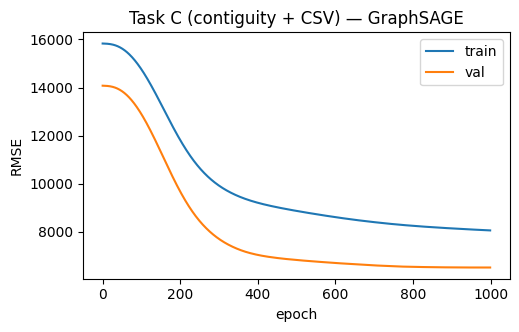

In [76]:
sage_reg_poly = SAGEReg(in_dim=data_poly.x.size(1), hidden_dim=64, dropout=0.2, aggr="mean")
train_rmse_sage_poly, val_rmse_sage_poly = train_node_regression(sage_reg_poly, data_poly, epochs=1000)
print("Final (GraphSAGE) RMSE train/val/test:", evaluate_regression(sage_reg_poly, data_poly))
print("Final (GCN) R2   train/val/test:", evaluate_regression_r2(sage_reg_poly, data_poly))

plot_learning_curve(train_rmse_sage_poly, val_rmse_sage_poly, "Task C (contiguity + CSV) — GraphSAGE", "RMSE")


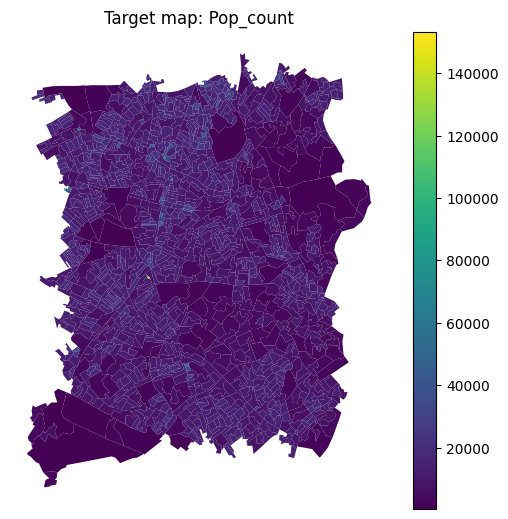

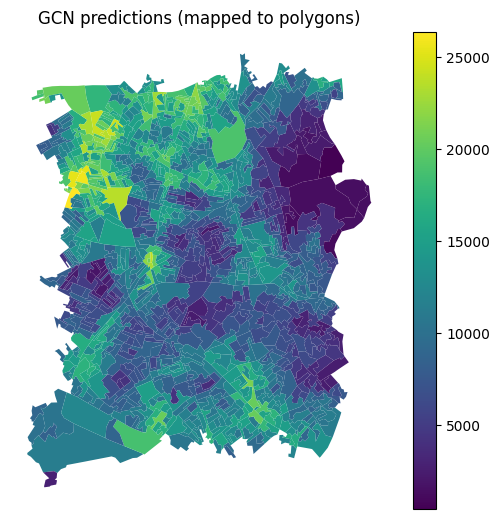

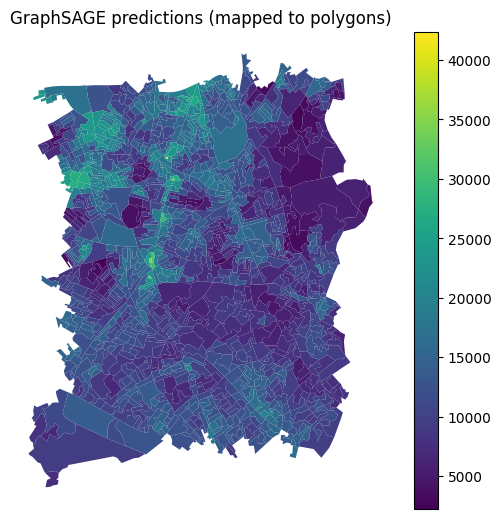

In [78]:
@torch.no_grad()
def predict_reg(model, data):
    model.eval()
    return model(data.x, data.edge_index).view(-1).cpu().numpy()

gdf_plot = gdf.copy()
gdf_plot["target"] = y.view(-1).cpu().numpy()

# GCN
gdf_plot["pred_gcn"] = predict_reg(gcn_reg_poly, data_poly)

# GraphSAGE
gdf_plot["pred_sage"] = predict_reg(sage_reg_poly, data_poly)

# Plot: target
ax = gdf_plot.plot(column="target", legend=True, figsize=(6.2, 6.2))
ax.set_title(f"Target map: {target_col}")
ax.axis("off")
plt.show()

# Plot: GCN prediction
ax = gdf_plot.plot(column="pred_gcn", legend=True, figsize=(6.2, 6.2))
ax.set_title("GCN predictions (mapped to polygons)")
ax.axis("off")
plt.show()

# Plot: GraphSAGE prediction
ax = gdf_plot.plot(column="pred_sage", legend=True, figsize=(6.2, 6.2))
ax.set_title("GraphSAGE predictions (mapped to polygons)")
ax.axis("off")
plt.show()


### Discussion prompts (Task C)
1. Compare **Queen** vs **Rook**: how do edge density and disconnected components affect performance?
2. Are the features $( \mathbf{X} )$ likely to be *exogenous*? What could cause leakage?
3. How would you design a **spatial split** (block CV) to reduce spatial autocorrelation leakage?
4. What additional baselines would you add (e.g., Ridge/Lasso, Random Forest, spatial lag model)?


## 8. Wrap-up and next steps

Key takeaways:
- Graph type and edge definition (SBM vs kNN vs contiguity vs street network) strongly influence outcomes.
- **GCN** is closely tied to normalised smoothing; **GraphSAGE** uses explicit aggregation (often more scalable).
- Always think carefully about **feature design**, **split strategy** (spatial leakage), and **edge semantics**.
